In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

from tabulate import tabulate

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")


path_d =  '/Users/jerzybala/Desktop/'

path_272K_org = '/Users/jerzybala/Desktop/BMJ paper revision/All_272K_Extended_1HotEncode_original.csv'

# Load data from a CSV file
#data = pd.read_csv('/Users/jerzybala/Desktop/2003_up_Oct_after_OHE_short.csv')
data = pd.read_csv(path_272K_org, index_col = 0)

print(data.shape)
data = data.dropna()
print(data.shape)

# **********************************************************************************************************************************

data = data.drop(columns =['Age=Under 18 years', 'Age=85+', ])
data.rename(columns={'Prolonged sexual abuse| or severe sexual assault': 'Prolonged sexual abuse or severe sexual assault'}, inplace=True)

old_names = ['Prefer not to say', 'None of the above', 'None of the above H', 'None of the above F', 'Other']
new_names = ['Prefer not to say about past traumas', 'No substance use', 'No covid trauma', 'No covid financial hardship', 'Other hardship at work' ]
data.rename(columns=dict(zip(old_names, new_names)), inplace=True)


old_gender_names = [
 'Gender=Female',
 'Gender=Male',
 'Gender=Non-binary/Third Gender',
 'Gender=Other/Intersex',
 'Gender=Prefer not to say']

new_gender_names = [
 'Biological_Sex=Female',
 'Biological_Sex=Male',
 'Biological_Sex=Non-binary/Third Gender',
 'Biological_Sex=Other/Intersex',
 'Biological_Sex=Prefer not to say']

data.rename(columns=dict(zip(old_gender_names, new_gender_names)), inplace=True)


# **********************************************************************************************************************************




region_mapping = {
    'Anglosphere': ['United States', 'Canada', 'United Kingdom', 'Ireland', 'New Zealand', 'Australia'],
    'Latin America': ['Argentina', 'Chile', 'Colombia', 'Ecuador', 'Guatemala', 'Mexico', 'Peru', 'Puerto Rico', 'Venezuela', 'Brazil', 'Bolivia', 'Paraguay', 'Uruguay'],
    'Middle East': ['Iraq', 'Saudi Arabia', 'United Arab Emirates', 'Yemen', 'Iran', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Qatar', 'Syria', 'Bahrain'],
    'French & Spanish Speaking Mainland Europe': ['Spain', 'France', 'Belgium', 'Switzerland', 'Portugal', 'Italy', 'Greece', 'Germany', 'Austria', 'Netherlands'],
    'West Africa': ['Cameroon', 'Cote d’Ivoire', 'Democratic Republic of the Congo', 'Nigeria', 'Ghana', 'Senegal', 'Mali', 'Niger', 'Guinea'],
    'North Africa': ['Algeria', 'Egypt', 'Morocco', 'Tunisia', 'Libya', 'Sudan'],
    'East & Southeast Asia': ['China', 'Japan', 'South Korea', 'North Korea', 'Vietnam', 'Thailand', 'Malaysia', 'Indonesia', 'Philippines', 'Singapore'],
    'South Asia': ['India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Nepal', 'Bhutan'],
    'Eastern Europe & Central Asia': ['Russia', 'Ukraine', 'Belarus', 'Moldova', 'Armenia', 'Azerbaijan', 'Georgia', 'Kazakhstan', 'Uzbekistan', 'Turkmenistan', 'Kyrgyzstan', 'Tajikistan'],
    'Scandinavia & Baltic': ['Sweden', 'Norway', 'Finland', 'Denmark', 'Iceland', 'Estonia', 'Latvia', 'Lithuania'],
    'Oceania & Pacific Islands': ['Fiji', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga'],
    'Sub-Saharan Africa': ['Kenya', 'Uganda', 'Tanzania', 'Rwanda', 'Burundi', 'South Africa', 'Zimbabwe', 'Zambia', 'Botswana', 'Namibia', 'Mozambique', 'Madagascar'],
    'Central America & Caribbean': ['Cuba', 'Dominican Republic', 'Haiti', 'Jamaica', 'Trinidad and Tobago', 'Barbados', 'Saint Lucia', 'Grenada', 'Belize', 'Costa Rica', 'El Salvador', 'Honduras', 'Nicaragua', 'Panama']
    # ... You can continue to add more regions and countries as needed.
}


# Invert the region mapping
country_to_region = {country: region for region, countries in region_mapping.items() for country in countries}

# Map each country to its region
data['Region'] = data['Country'].map(country_to_region)

# Now 'data' has an additional column 'Region' which indicates the region of each country



main_regions = [
'Anglosphere',
'Latin America',
'South Asia',
'North Africa',
'French & Spanish Speaking Mainland Europe',
'Sub-Saharan Africa',
'West Africa',
'Middle East',
'East & Southeast Asia']    

# **********************************************************************************************************************************



def reconstruct_age_category(data):
    # Define the age range columns
    age_columns = [
        'Age=18-24', 'Age=25-34', 'Age=35-44', 'Age=45-54', 
        'Age=55-64', 'Age=65-74', 'Age=75-84'
    ]

    # Function to find the age category for each row
    def find_age_category(row):
        for col in age_columns:
            if row[col] == 1:
                return col.replace('Age=', 'Age=')
        return 'Unknown'  # Return 'Unknown' if no category matches

    # Apply the function to each row
    data['Age'] = data.apply(find_age_category, axis=1)

    # Optionally, drop the original OHE age columns
    #data = data.drop(columns=age_columns)

    return data

# Applying the function to your data
data = reconstruct_age_category(data)
# Now 'data' has a reconstructed 'Age' column



age_columns = ['Age=18-24', 'Age=25-34', 'Age=35-44', 'Age=45-54', 'Age=55-64', 'Age=65-74', 'Age=75-84']
gender_columns = [
 'Biological_Sex=Female',
 'Biological_Sex=Male',
 'Biological_Sex=Non-binary/Third Gender',
 'Biological_Sex=Other/Intersex',
 'Biological_Sex=Prefer not to say']

def reconstruct_category(data, columns, feature_name):
    # Function to find the age category for each row
    def find_age_category(row):
        for col in columns:
            if row[col] == 1:
                return col.replace(feature_name + "=", feature_name + "=")
        return 'Unknown'  # Return 'Unknown' if no category matches

    # Apply the function to each row
    data[feature_name] = data.apply(find_age_category, axis=1)

    # Optionally, drop the original OHE age columns
    #data = data.drop(columns=age_columns)

    return data


# Applying the function to your data
data = reconstruct_category(data, age_columns, 'Age')
data = reconstruct_category(data, gender_columns, 'Biological_Sex')



# **********************************************************************************************************************************


data['MHQ Sign'] = data['MHQ Sign'].replace({'Plus': 1, 'Minus': 0})

'''
data = data.dropna()
data.shape
data = data[data['Region'].isin(main_regions)]
data.shape
'''

'''
# Define the mapping dictionary
age_mapping = {
    'Age=18-24': 1,
    'Age=25-34': 2,
    'Age=35-44': 3,
    'Age=45-54': 4,
    'Age=55-64': 5,
    'Age=65-74': 6,
    'Age=75-84': 7,
    'Age=85+': 8
}
# Apply the mapping to create the 'Age_n' column
data['Age_n'] = data['Age'].map(age_mapping)
'''

MedCon = [
'Type II Diabetes',
 'Fibromyalgia',
 'Liver disease/Cirrhosis',
 'Hypertension',
 'Irritable Bowel Syndrome',
 'Heart disease',
 "Inflammatory Bowel Disease / Crohn's disease",
 'Arthritis',
 'Psoriasis',
 'Asthma',
 'Migraines',
 'Traumatic Brain Injury',
 'Osteoporosis',
 'Sleep apnea',
 'Hipotiroidismo',
 'Neuropathy',
 'Cancer',
 'Chronic Obstructive Pulmonary Disease (COPD)',
 'HIV /AIDS',
 'Kidney Disease',
 'Rheumatoid',
 'Polycystic ovaries',
 'Narcolepsy',
 'Chronic fatigue syndrome',
 'Back problem',
 'Epilepsy',
 'Multiple sclerosis',
 'Escoliosis',
 'Stroke',
 'Herpes',
 'Type 1 Diabetes']

data['Number of Medical Conditions'] = data[MedCon].sum(axis=1)



SubNum = ['Type 1 Diabetes',
 'Tobacco products',
 'Alcoholic beverages',
 'Cannabis',
 'Vaping products',
 'Sedatives or Sleeping Pills',
 'Amphetamine type stimulants (e.g. speed| diet pills| ecstasy| etc.)',
 'Opioids',
 'Melatonina',
 'Cigarrillo']

data['Number of Subtances'] = data[SubNum].sum(axis=1)


def apply_one_hot_encoding(data, column_for_OHE, drop_original=False):
    """
    Apply one-hot encoding to a specified column in a DataFrame and optionally keep the original column.

    Parameters:
    data (DataFrame): The input DataFrame.
    column_for_OHE (str): The column to which one-hot encoding will be applied.
    drop_original (bool): Whether to drop the original column after encoding.

    Returns:
    DataFrame: The DataFrame with one-hot encoded column.
    """
    # Create one-hot encoded DataFrame
    encoded_df = pd.get_dummies(data[column_for_OHE], prefix=column_for_OHE)

    # Concatenate the original DataFrame with the encoded DataFrame
    result_df = pd.concat([data, encoded_df], axis=1)

    # Dropping the original column if specified
    if drop_original:
        result_df.drop(column_for_OHE, axis=1, inplace=True)

    return result_df

print(data.shape)
remove_range_MD = range(7, 13)
data = data[~data['Number of Medical Conditions'].isin(remove_range_MD)]

data = apply_one_hot_encoding(data, 'Language', drop_original=False)



columns_for_OHE = [
'Number of Traumas',
'Number of Medical Conditions',
'Number of Subtances']

for col in columns_for_OHE:
    data = apply_one_hot_encoding(data, col, drop_original=True)


dataL = data.drop(columns=['Region', 'Age', 'Biological_Sex', 'Language', 'Overall MHQ', 'MHQ Levels', 'Country' ])



dataR = dataL
dataR['Overall MHQ'] = data['Overall MHQ']
dataR = dataR.drop(columns='MHQ Sign')
dataL = dataL.drop(columns='Overall MHQ')


dataL.to_csv('/Users/jerzybala/Desktop/dataL.csv', index=False)
dataR.to_csv('/Users/jerzybala/Desktop/dataR.csv', index=False)


: 

In [89]:
# dataL.columns.tolist()
dataL.to_csv('/Users/jerzybala/Desktop/dataL.csv', index=False)


# XGBOOST Runs


# run_xgboost ==> running in CV mode

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def run_xgboost_cv(data, target_col, xgb_params={}, cv_folds=3, use_sample=False, sample_size=0.3):
    """
    Run XGBoost with cross-validation, return performance metrics and feature importances.

    Parameters:
    data (DataFrame): The input data.
    target_col (str): The name of the target column.
    xgb_params (dict, optional): Parameters for the XGBoost classifier.
    cv_folds (int, optional): Number of folds for cross-validation.
    use_sample (bool, optional): Whether to use a stratified sample of the data.
    sample_size (float, optional): Fraction of data to use in the sample (between 0 and 1).

    Returns:
    Tuple: (Dictionary containing performance metrics, DataFrame containing feature importances)
    """
    if use_sample:
        data, _ = train_test_split(data, train_size=sample_size, stratify=data[target_col])

    X = data.drop(target_col, axis=1)
    y = data[target_col]

    # Create the XGBoost classifier using xgb_params
    xgb_clf = xgb.XGBClassifier(**xgb_params)


    '''
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary'),
        'f1': make_scorer(f1_score, average='binary'),
        'roc_auc': make_scorer(roc_auc_score)
    }
    '''



    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted'),
        'roc_auc': make_scorer(roc_auc_score)
        # ROC AUC for multiclass might require a custom implementation
}



    
    feature_importances = np.zeros(X.shape[1])
    skf = StratifiedKFold(n_splits=cv_folds)

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        xgb_clf.fit(X_train, y_train)
        feature_importances += xgb_clf.feature_importances_

    feature_importances /= cv_folds

    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    cv_results = cross_validate(xgb_clf, X, y, cv=skf, scoring=scoring)
    performance_metrics = {metric: cv_results[f"test_{metric}"] for metric in scoring.keys()}

    return performance_metrics, feature_importance_df

xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1
}

results, feature_importance_xgb = run_xgboost_cv(
    dataL,
    'MHQ Sign',
    xgb_params=xgb_params,
    cv_folds=5,
    use_sample=False,
    sample_size=1.0
)


# Assuming 'results' is the dictionary returned by the 'run_xgboost_cv' function

metrics = []
averages = {}
for metric, scores in results.items():
    for fold_index, score in enumerate(scores, start=1):
        metrics.append({
            'Metric': metric,
            'Fold': fold_index,
            'Score': score
        })
    # Calculate and store the average for each metric
    averages[metric] = np.mean(scores)

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

# Append the averages at the end of the DataFrame
for metric, avg_score in averages.items():
    metrics_df = metrics_df.append({'Metric': metric, 'Fold': 'Average', 'Score': avg_score}, ignore_index=True)

# Display the DataFrame
print(metrics_df)


# Random Forest

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def run_random_forest(data, target_col, rf_params={}, test_size=0.3, random_state=None):
    """
    Train and evaluate a Random Forest classifier with the specified parameters.

    Parameters:
    - data: DataFrame, the input data with features and the target column.
    - target_col: str, the name of the target column.
    - rf_params: dict, Random Forest hyperparameters (default: {}).
    - test_size: float, the proportion of the dataset to include in the test split (default: 0.3).
    - random_state: int or None, random seed for reproducibility (default: None).

    Returns:
    - float, the accuracy score of the trained Random Forest classifier on the test data.
    - dict, a dictionary of feature importances.
    """
    # Extract features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create the Random Forest classifier with the specified parameters
    rf_classifier = RandomForestClassifier(**rf_params)

    # Train the classifier on the training data
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = rf_classifier.predict(X_test)

    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    # Get feature importances
    feature_importances = rf_classifier.feature_importances_
    feature_names = X.columns.tolist()
    feature_importance_dict = dict(zip(feature_names, feature_importances))

    return accuracy, feature_importance_dict




In [19]:
accuracy, feature_importance_dict = run_random_forest(dataL, 'MHQ Sign', rf_params, test_size=0.3, random_state=42)

print(f'Accuracy: {accuracy}')
print('Feature Importances:')
for feature, importance in feature_importance_dict.items():
    print(f'{feature}: {importance}')


# Convert the dictionary to a DataFrame for plotting
feature_importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=['Feature', 'Importance'])

# Plotting
plt.figure(figsize=(12, 40))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values('Importance', ascending=False))
plt.title('Feature Importance DF')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


NameError: name 'target_col' is not defined

# ROC Curves, other figures


In [142]:
dataL = dataL.drop(columns='Overall MHQ')
                  

In [6]:
dataR.columns.tolist()


['Age=18-24',
 'Age=25-34',
 'Age=35-44',
 'Age=45-54',
 'Age=55-64',
 'Age=65-74',
 'Age=75-84',
 "Education=Bachelor's Degree",
 'Education=High School',
 "Education=Master's Degree",
 'Education=Other',
 'Education=Ph.D. or higher',
 'Education=Prefer not to say',
 'Education=Primary Education',
 'Education=Professional Certificate',
 'Education=Some High School',
 'Education=Vocational certification',
 'Employment=Employed /Self employed',
 'Employment=Homemaker',
 'Employment=Not able to work',
 'Employment=Retired',
 'Employment=Studying',
 'Employment=Unemployed',
 'In general, I get as much sleep as I need:=All of the time',
 'In general, I get as much sleep as I need:=Hardly ever',
 'In general, I get as much sleep as I need:=Most of the time',
 'In general, I get as much sleep as I need:=Some of the time',
 'In general, I get as much sleep as I need:=Sometimes',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Every day',
 'How regularly to you engage 

# run_xgboost2  ==>  running in test/train mode

Performance Metrics:
   accuracy  precision    recall        f1   roc_auc
0  0.799086   0.786801  0.799086  0.786939  0.829729

Top Feature Importances:
                                               Feature  Importance
0                                            Age=18-24    0.156001
35   How regularly do you socialize with friends in...    0.095501
24   In general, I get as much sleep as I need:=Har...    0.071612
1                                            Age=25-34    0.047427
20                                  Employment=Retired    0.036289
25   In general, I get as much sleep as I need:=Mos...    0.033488
32   How regularly to you engage in physical exerci...    0.029831
19                         Employment=Not able to work    0.025418
36   How regularly do you socialize with friends in...    0.022587
23   In general, I get as much sleep as I need:=All...    0.021188
90                         Sedatives or Sleeping Pills    0.015946
5                                          

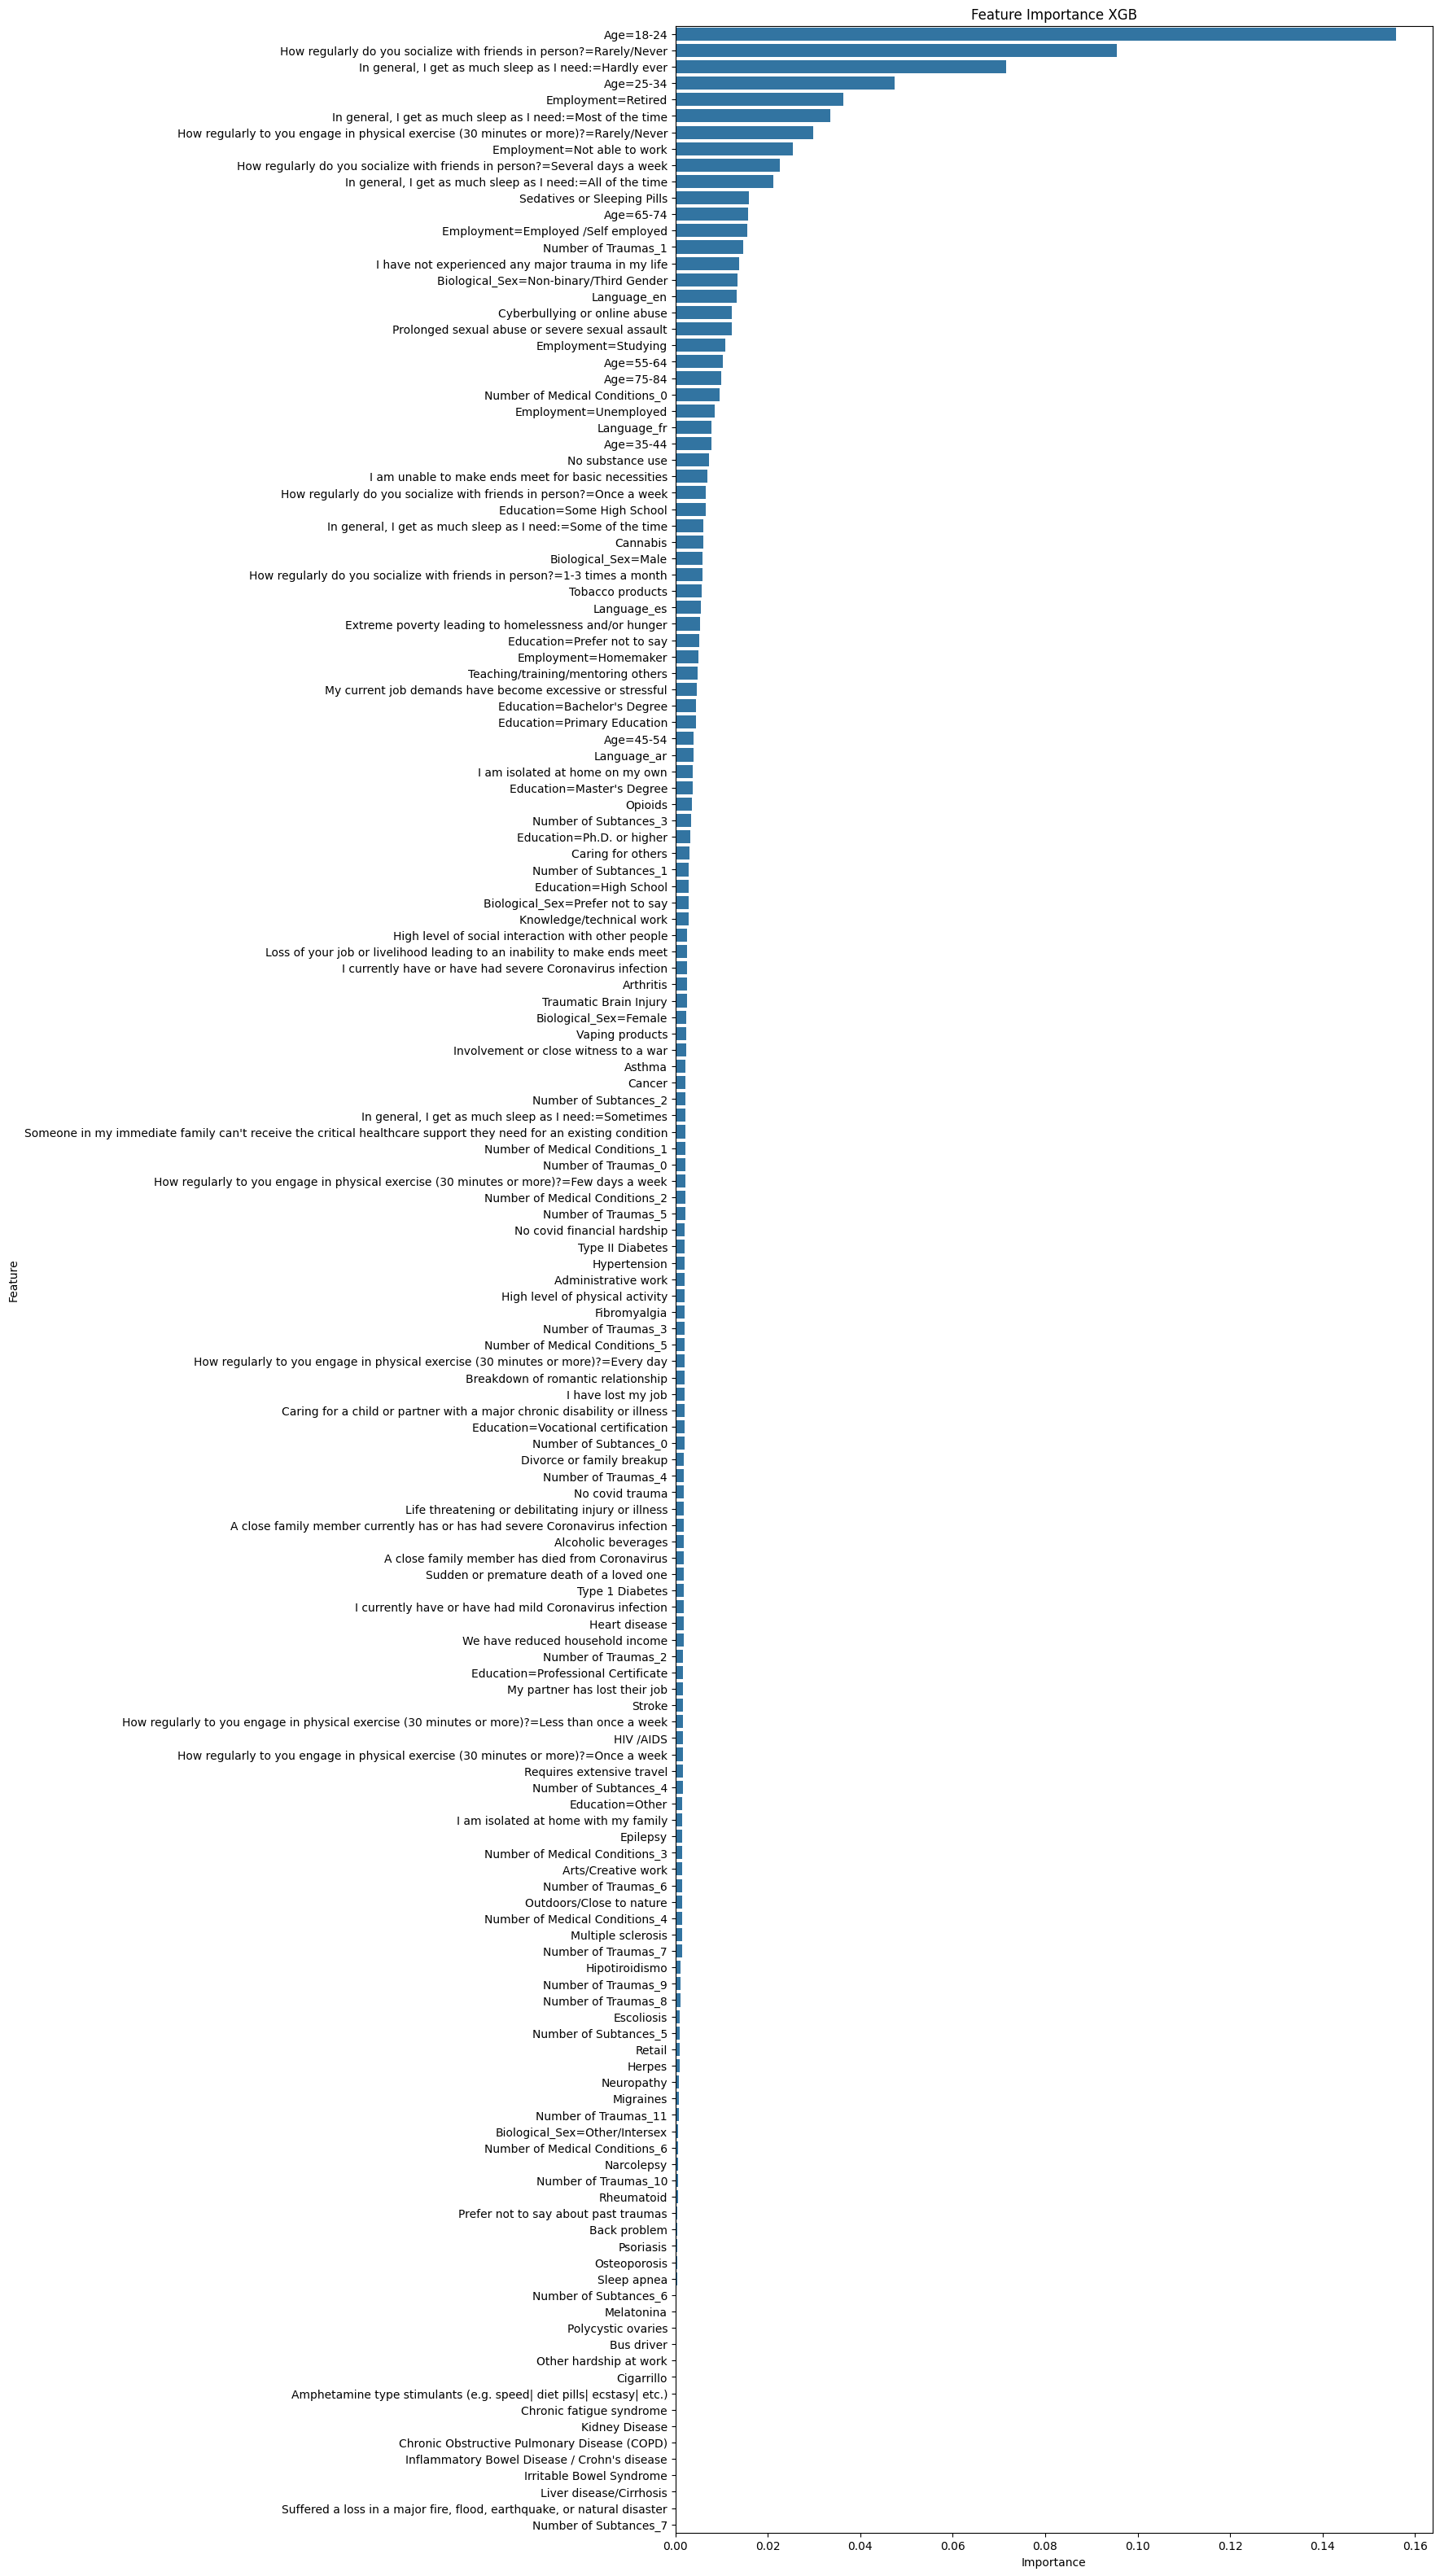

In [28]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def run_xgboost2(data, target_col, xgb_params={}, test_size=0.3, random_state=None):
    """
    Train and evaluate XGBoost model using a train-test split and return feature importances.

    Parameters:
    data (DataFrame): The input data.
    target_col (str): The name of the target column.
    xgb_params (dict, optional): Parameters for the XGBoost classifier.
    test_size (float, optional): Proportion of the dataset to include in the test split.
    random_state (int, optional): Controls the shuffling applied to the data before applying the split.

    Returns:
    Tuple: (Dictionary containing performance metrics, DataFrame containing feature importances)
    """
    # Splitting the data
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Train the XGBoost classifier
    xgb_clf = xgb.XGBClassifier(**xgb_params)
    xgb_clf.fit(X_train, y_train)

    # Predictions
    y_pred = xgb_clf.predict(X_test)
    y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

    # Calculating performance metrics

    '''
    performance_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary'),
        'recall': recall_score(y_test, y_pred, average='binary'),
        'f1': f1_score(y_test, y_pred, average='binary'),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    '''
    
    performance_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    
    # Extracting feature importances
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': xgb_clf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    return performance_metrics, feature_importances



xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1
}



results, feature_importance_xgb = run_xgboost2(dataL, 'MHQ Sign', xgb_params=xgb_params, test_size=0.3, random_state=42)


# Printing results in a tabular format
print("Performance Metrics:")
print(pd.DataFrame([results]))

# Printing top feature importances
print("\nTop Feature Importances:")
print(feature_importance_xgb.head(30))  # Adjust number of top features to display as needed


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 40))
sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb)
plt.title('Feature Importance XGB')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()




In [8]:

print(tabulate(feature_importance_xgb, headers='keys', tablefmt='presto'), "\n")



     | Feature                                                                                                          |   Importance
-----+------------------------------------------------------------------------------------------------------------------+--------------
   0 | Age=18-24                                                                                                        |  0.156001
  35 | How regularly do you socialize with friends in person?=Rarely/Never                                              |  0.0955015
  24 | In general, I get as much sleep as I need:=Hardly ever                                                           |  0.0716121
   1 | Age=25-34                                                                                                        |  0.0474274
  20 | Employment=Retired                                                                                               |  0.036289
  25 | In general, I get as much sleep as I need:=Most of the time

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

def run_models(data, target_col, models, test_size=0.3, random_state=None):
    """
    Train and evaluate multiple machine learning models using a train-test split and return performance metrics.

    Parameters:
    data (DataFrame): The input data.
    target_col (str): The name of the target column.
    models (dict): Dictionary containing model names as keys and model objects as values.
    test_size (float, optional): Proportion of the dataset to include in the test split.
    random_state (int, optional): Controls the shuffling applied to the data before applying the split.

    Returns:
    Dict: Dictionary containing performance metrics for each model.
    """
    performance_metrics = {}
    
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        model_metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'roc_auc': roc_auc_score(y_test, y_pred_proba)
        }
        
        performance_metrics[model_name] = model_metrics

    return performance_metrics

# Define the models you want to run
models = {
    'LogisticRegression': LogisticRegression(),
    'NaiveBayes': GaussianNB(),
    'RandomForest': RandomForestClassifier()
}

# Run the models
results = run_models(dataL, 'MHQ Sign', models, test_size=0.3, random_state=42)

# Printing results in a tabular format
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print()

    
    
    


Model: LogisticRegression
accuracy: 0.7971
precision: 0.7841
recall: 0.7971
f1: 0.7831
roc_auc: 0.8268

Model: NaiveBayes
accuracy: 0.7463
precision: 0.7229
recall: 0.7463
f1: 0.7277
roc_auc: 0.7600

Model: RandomForest
accuracy: 0.7869
precision: 0.7720
recall: 0.7869
f1: 0.7724
roc_auc: 0.8055



In [22]:
from tabulate import tabulate

# ... (Previous code)

# Printing results in a tabular format using tabulate
table_data = []
for model_name, metrics in results.items():
    row = [model_name] + [f"{value:.4f}" for value in metrics.values()]
    table_data.append(row)

headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"]

# Print the table
table = tabulate(table_data, headers, tablefmt="presto")
print(table)

 Model              |   Accuracy |   Precision |   Recall |   F1-Score |   ROC AUC
--------------------+------------+-------------+----------+------------+-----------
 LogisticRegression |     0.7971 |      0.7841 |   0.7971 |     0.7831 |    0.8268
 NaiveBayes         |     0.7463 |      0.7229 |   0.7463 |     0.7277 |    0.76
 RandomForest       |     0.7869 |      0.772  |   0.7869 |     0.7724 |    0.8055


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def run_model_for_each_category(data, categorical_feature, target_col, test_size, random_state):
    category_results = {}

    # Get unique values in the categorical feature
    unique_categories = data[categorical_feature].unique()

    for category in unique_categories:
        # Segmenting the data
        category_data = data[data[categorical_feature] == category]

        # Drop the categorical feature column from this segment
        category_data = category_data.drop(columns=[categorical_feature])

        # Ensure the segment is not empty
        if not category_data.empty:
            # Splitting the data
            X = category_data.drop(columns=[target_col])
            y = category_data[target_col]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

            # Initialize models
            models = {
                'LogisticRegression': LogisticRegression(),
                'NaiveBayes': GaussianNB(),
                'RandomForest': RandomForestClassifier()
            }

            # Dictionary to hold performance metrics
            performance_metrics = {}

            for model_name, model in models.items():
                print(f" now runing {model_name}")
                # Train model
                model.fit(X_train, y_train)
                # Predictions
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1]

                # Calculating performance metrics
                metrics = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred, average='weighted'),
                    'recall': recall_score(y_test, y_pred, average='weighted'),
                    'f1': f1_score(y_test, y_pred, average='weighted'),
                    'roc_auc': roc_auc_score(y_test, y_pred_proba)
                }

                performance_metrics[model_name] = metrics

            # Store the results in the dictionary
            category_results[category] = performance_metrics

    return category_results



# Parameters
#categorical_feature = 'Language'
target_col = 'MHQ Sign'
test_size = 0.3
random_state = 42

# Running the function
results2 = run_model_for_each_category(dataL, categorical_feature, target_col, test_size, random_state)


# Displaying the results
for category, metrics in results2.items():
    print(f"Category: {category}")
    for model_name, performance in metrics.items():
        print(f"  Model: {model_name}")
        for metric, value in performance.items():
            print(f"    {metric}: {value:.2f}")
    print()


# Performance characteristics by categories of features used


In [29]:
#dataL.columns.tolist()


In [47]:
demographics1 = ['Age=18-24',
 'Age=25-34',
 'Age=35-44',
 'Age=45-54',
 'Age=55-64',
 'Age=65-74',
 'Age=75-84',
 "Education=Bachelor's Degree",
 'Education=High School',
 "Education=Master's Degree",
 'Education=Other',
 'Education=Ph.D. or higher',
 'Education=Prefer not to say',
 'Education=Primary Education',
 'Education=Professional Certificate',
 'Education=Some High School',
 'Education=Vocational certification',
 'Employment=Employed /Self employed',
 'Employment=Homemaker',
 'Employment=Not able to work',
 'Employment=Retired',
 'Employment=Studying',
 'Employment=Unemployed',
 'Biological_Sex=Female',
 'Biological_Sex=Male',
 'Biological_Sex=Non-binary/Third Gender',
 'Biological_Sex=Other/Intersex',
 'Biological_Sex=Prefer not to say',
 'Language_ar',
 'Language_en',
 'Language_es',
 'Language_fr']

lifestyle = [
 'In general, I get as much sleep as I need:=All of the time',
 'In general, I get as much sleep as I need:=Hardly ever',
 'In general, I get as much sleep as I need:=Most of the time',
 'In general, I get as much sleep as I need:=Some of the time',
 'In general, I get as much sleep as I need:=Sometimes',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Every day',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Few days a week',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Less than once a week',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Once a week',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Rarely/Never',
 'How regularly do you socialize with friends in person?=1-3 times a month',
 'How regularly do you socialize with friends in person?=Once a week',
 'How regularly do you socialize with friends in person?=Rarely/Never',
 'How regularly do you socialize with friends in person?=Several days a week']

traumas = [ 
 'Prolonged sexual abuse or severe sexual assault',
 'Cyberbullying or online abuse',
 'Loss of your job or livelihood leading to an inability to make ends meet',
 'Divorce or family breakup',
 'Sudden or premature death of a loved one',
 'Caring for a child or partner with a major chronic disability or illness',
 'I have not experienced any major trauma in my life',
 'Breakdown of romantic relationship',
 'Life threatening or debilitating injury or illness',
 'Involvement or close witness to a war',
 'Suffered a loss in a major fire, flood, earthquake, or natural disaster',
 'Extreme poverty leading to homelessness and/or hunger',
 'Prefer not to say about past traumas',
    
 'My current job demands have become excessive or stressful',
 'We have reduced household income',
 'I have lost my job',
 'My partner has lost their job',
 'Other hardship at work',
 'I am unable to make ends meet for basic necessities',
 'No covid financial hardship',
 'A close family member has died from Coronavirus',
 'A close family member currently has or has had severe Coronavirus infection',
 'I am isolated at home with my family',
 'I currently have or have had mild Coronavirus infection',
 'I am isolated at home on my own',
 "Someone in my immediate family can't receive the critical healthcare support they need for an existing condition",
 'I currently have or have had severe Coronavirus infection',
 'No covid trauma']


medical_conditions = [
 'Type II Diabetes',
 'Fibromyalgia',
 'Liver disease/Cirrhosis',
 'Hypertension',
 'Irritable Bowel Syndrome',
 'Heart disease',
 "Inflammatory Bowel Disease / Crohn's disease",
 'Arthritis',
 'Psoriasis',
 'Asthma',
 'Migraines',
 'Traumatic Brain Injury',
 'Osteoporosis',
 'Sleep apnea',
 'Hipotiroidismo',
 'Neuropathy',
 'Cancer',
 'Chronic Obstructive Pulmonary Disease (COPD)',
 'HIV /AIDS',
 'Kidney Disease',
 'Rheumatoid',
 'Polycystic ovaries',
 'Narcolepsy',
 'Chronic fatigue syndrome',
 'Back problem',
 'Epilepsy',
 'Multiple sclerosis',
 'Escoliosis',
 'Stroke',
 'Herpes',
 'Type 1 Diabetes']

substance_use = [
 'Tobacco products',
 'Alcoholic beverages',
 'Cannabis',
 'Vaping products',
 'Sedatives or Sleeping Pills',
 'Amphetamine type stimulants (e.g. speed| diet pills| ecstasy| etc.)',
 'Opioids',
 'Melatonina',
 'Cigarrillo',
 'No substance use']

trauma_number = [
 'Number of Traumas_0',
 'Number of Traumas_1',
 'Number of Traumas_2',
 'Number of Traumas_3',
 'Number of Traumas_4',
 'Number of Traumas_5',
 'Number of Traumas_6',
 'Number of Traumas_7',
 'Number of Traumas_8',
 'Number of Traumas_9',
 'Number of Traumas_10',
 'Number of Traumas_11']

lifestyle_exercise = [
 'How regularly to you engage in physical exercise (30 minutes or more)?=Every day',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Few days a week',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Less than once a week',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Once a week',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Rarely/Never']

lifestyle_sleep = [
 'In general, I get as much sleep as I need:=All of the time',
 'In general, I get as much sleep as I need:=Hardly ever',
 'In general, I get as much sleep as I need:=Most of the time',
 'In general, I get as much sleep as I need:=Some of the time',
 'In general, I get as much sleep as I need:=Sometimes']

lifestyle_socializing = [
 'How regularly do you socialize with friends in person?=1-3 times a month',
 'How regularly do you socialize with friends in person?=Once a week',
 'How regularly do you socialize with friends in person?=Rarely/Never',
 'How regularly do you socialize with friends in person?=Several days a week']

demograhics2 = [
 'Age=18-24',
 'Age=25-34',
 'Age=35-44',
 'Age=45-54',
 'Age=55-64',
 'Age=65-74',
 'Age=75-84',
 
 'Biological_Sex=Female',
 'Biological_Sex=Male',
 'Biological_Sex=Non-binary/Third Gender',
 'Biological_Sex=Other/Intersex',
 'Biological_Sex=Prefer not to say',
 'Language_ar',
 'Language_en',
 'Language_es',
 'Language_fr']


employment = [
 'Employment=Employed /Self employed',
 'Employment=Homemaker',
 'Employment=Not able to work',
 'Employment=Retired',
 'Employment=Studying',
 'Employment=Unemployed']


education = [
    
 "Education=Bachelor's Degree",
 'Education=High School',
 "Education=Master's Degree",
 'Education=Other',
 'Education=Ph.D. or higher',
 'Education=Prefer not to say',
 'Education=Primary Education',
 'Education=Professional Certificate',
 'Education=Some High School',
 'Education=Vocational certification']
    

# Define combinations
feature_combinations = {
    'Demographics1 (age; gender, language; education; employment': demographics1,
    'Demographics1 Lifestyle (exercise, sleep, socializing': demographics1 + lifestyle,
    'Demographics1 + Lifestyle + Traumas': demographics1 + lifestyle + traumas,
    'Demographics1 + Lifestyle + Traumas + Medical Conditions': demographics1 + lifestyle + traumas + medical_conditions,
    'Demographics1 + Lifestyle + Traumas + Medical Conditions + Substance Use': demographics1 + lifestyle + traumas +medical_conditions + substance_use,
    'Lifestyle': lifestyle,
    'Lifestyle + Traumas': lifestyle + traumas,
    'Lifestyle + Number of Traumas': lifestyle + trauma_number,
    'Lifestyle + Number of Traumas + Traumas': lifestyle + trauma_number + traumas,
    'Traumas': traumas,
    'Traumas + Lifestyle (excersie)': traumas + lifestyle_exercise,
    'Traumas + Lifestyle (excersie + sleep)': traumas + lifestyle_exercise + lifestyle_sleep,
    'Traumas + Lifestyle (excersie + sleep + socializing)': traumas + lifestyle_exercise + lifestyle_sleep + lifestyle_socializing,
    'Demographic2 (age, gender, languag': demograhics2,
    'Demographic2 + Traumas': demograhics2 + traumas,
    'Demographic2 + Eduction + Employment': demograhics2 + education + employment


    # Add more combinations as needed
}



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import xgboost as xgb
from tabulate import tabulate



# Prepare a table to store the results
results = []

for combo_name, features in feature_combinations.items():
    X = dataL[features]
    y = dataL['MHQ Sign']
    print(combo_name)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    

    # Train the model
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    ca = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Add results to the table
    results.append([combo_name, auc, ca, f1, precision, recall])

# Display the results
print(tabulate(results, headers=["Combination", "AUC", "Accuracy", "F1 Score", "Precision", "Recall"], tablefmt='presto'))




Demographics1 (age; gender, language; education; employment
Demographics1 Lifestyle (exercise, sleep, socializing
Demographics1 + Lifestyle + Traumas
Demographics1 + Lifestyle + Traumas + Medical Conditions
Demographics1 + Lifestyle + Traumas + Medical Conditions + Substance Use
Lifestyle
Lifestyle + Traumas
Lifestyle + Number of Traumas
Lifestyle + Number of Traumas + Traumas
Traumas
Traumas + Lifestyle (excersie)
Traumas + Lifestyle (excersie + sleep)
Traumas + Lifestyle (excersie + sleep + socializing)
Demographic2 (age, gender, languag
Demographic2 + Traumas
Demographic2 + Eduction + Employment
 Combination                                                              |      AUC |   Accuracy |   F1 Score |   Precision |   Recall
--------------------------------------------------------------------------+----------+------------+------------+-------------+----------
 Demographics1 (age; gender, language; education; employment              | 0.766526 |   0.763502 |   0.850862 |    0.793

In [ ]:
all_features_reduandent = demograhics1 +lifestyle+traumas +medical_conditions +substance_use+trauma_number+lifestyle_exercise+lifestyle_sleep+lifestyle_ssocializing+demograhics2+employment +education



In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
from tabulate import tabulate

# Define your feature combinations and dataL as before
# ...

# XGBoost parameters
xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Prepare a table to store the results
results = []

for combo_name, features in feature_combinations.items():
    X = dataL[features]
    y = dataL['MHQ Sign']
    print(combo_name)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train the model
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate performance metrics
    performance_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

    # Add results to the table
    results.append([
        combo_name, 
        performance_metrics['roc_auc'], 
        performance_metrics['accuracy'], 
        performance_metrics['f1'], 
        performance_metrics['precision'], 
        performance_metrics['recall']
    ])

# Display the results
print(tabulate(results, headers=["Combination", "ROC AUC", "Accuracy", "F1 Score", "Precision", "Recall"], tablefmt='presto'))


Demographics1 (age; gender, language; education; employment
Demographics1 Lifestyle (exercise, sleep, socializing
Demographics1 + Lifestyle + Traumas
Demographics1 + Lifestyle + Traumas + Medical Conditions
Demographics1 + Lifestyle + Traumas + Medical Conditions + Substance Use
Lifestyle
Lifestyle + Traumas
Lifestyle + Number of Traumas
Lifestyle + Number of Traumas + Traumas
Traumas
Traumas + Lifestyle (excersie)
Traumas + Lifestyle (excersie + sleep)
Traumas + Lifestyle (excersie + sleep + socializing)
Demographic2 (age, gender, languag
Demographic2 + Traumas
Demographic2 + Eduction + Employment
 Combination                                                              |   ROC AUC |   Accuracy |   F1 Score |   Precision |   Recall
--------------------------------------------------------------------------+-----------+------------+------------+-------------+----------
 Demographics1 (age; gender, language; education; employment              |  0.766738 |   0.763625 |   0.739423 |    0.

In [ ]:
  performance_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    


In [58]:
import random
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import xgboost as xgb
from tabulate import tabulate

# Load your dataset
# dataL = pd.read_csv('your_data.csv')

# Define your feature categories
categories = {
    'Demographics1': demographics1,
    'Lifestyle': lifestyle,
    'Traumas': traumas,
    'Medical Conditions': medical_conditions,
    'Substance Use': substance_use,
    'Trauma Number': trauma_number,
    # ... other categories
}

# Function to check and remove duplicate features
def remove_duplicates(categories):
    all_features = set()
    for key, features in categories.items():
        unique_features = set(features) - all_features
        all_features.update(unique_features)
        categories[key] = list(unique_features)
    return categories

# Remove duplicates from categories
categories = remove_duplicates(categories)

# Function to evaluate a combination of categories
def evaluate_combination(combination):
    features = list(itertools.chain.from_iterable(categories[cat] for cat in combination))
    X = dataL[features]
    y = dataL['MHQ Sign']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    return {
        "AUC": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred)
    }

# ...

# Randomly select combinations and evaluate
num_combinations = 100  # Define how many combinations you want to test
results = []

for _ in range(num_combinations):
    random_combination = random.sample(categories.keys(), random.randint(1, len(categories)))
    print(random_combination)
    performance = evaluate_combination(random_combination)
    results.append([
        " + ".join(random_combination), 
        performance['AUC'], 
        performance['Accuracy'], 
        performance['F1'], 
        performance['Precision'], 
        performance['Recall']
    ])

# Sort the results by F1 score in descending order
results.sort(key=lambda x: x[3], reverse=True)

# Display the sorted results
print(tabulate(results, headers=["Combination", "AUC", "Accuracy", "F1 Score", "Precision", "Recall"], tablefmt='presto'))



['Substance Use', 'Lifestyle', 'Demographics1', 'Trauma Number', 'Traumas', 'Medical Conditions']
['Substance Use', 'Traumas', 'Lifestyle']
['Traumas', 'Trauma Number', 'Demographics1', 'Medical Conditions', 'Substance Use', 'Lifestyle']
['Medical Conditions', 'Demographics1']
['Medical Conditions', 'Substance Use', 'Lifestyle']
['Lifestyle']
['Traumas', 'Demographics1', 'Lifestyle', 'Medical Conditions', 'Trauma Number', 'Substance Use']
['Trauma Number', 'Traumas', 'Substance Use', 'Medical Conditions']
['Medical Conditions', 'Traumas', 'Lifestyle', 'Substance Use', 'Demographics1', 'Trauma Number']
['Medical Conditions', 'Traumas']
['Traumas', 'Medical Conditions', 'Trauma Number', 'Substance Use', 'Lifestyle']
['Substance Use', 'Trauma Number', 'Demographics1']
['Trauma Number', 'Medical Conditions', 'Substance Use', 'Lifestyle']
['Trauma Number', 'Substance Use', 'Lifestyle']
['Traumas', 'Substance Use']
['Substance Use', 'Traumas', 'Medical Conditions', 'Lifestyle']
['Substance U

In [65]:
import random
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
from tabulate import tabulate

# Load your dataset
# dataL = pd.read_csv('your_data.csv')

# Define your feature categories
categories = {
    'Demographics1': demographics1,
    'Lifestyle': lifestyle,
    'Traumas': traumas,
    'Medical Conditions': medical_conditions,
    'Substance Use': substance_use,
    'Trauma Number': trauma_number,
    # ... other categories
}

# Function to check and remove duplicate features
def remove_duplicates(categories):
    all_features = set()
    for key, features in categories.items():
        unique_features = set(features) - all_features
        all_features.update(unique_features)
        categories[key] = list(unique_features)
    return categories

# Remove duplicates from categories
categories = remove_duplicates(categories)

# XGBoost parameters
xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Function to evaluate a combination of categories
def evaluate_combination(combination):
    features = list(itertools.chain.from_iterable(categories[cat] for cat in combination))
    X = dataL[features]
    y = dataL['MHQ Sign']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

# Randomly select combinations and evaluate
num_combinations = 100  # Define how many combinations you want to test
results = []

for _ in range(num_combinations):
    random_combination = random.sample(categories.keys(), random.randint(1, len(categories)))
    print(random_combination)
    performance = evaluate_combination(random_combination)
    results.append([
        " + ".join(random_combination), 
        performance['roc_auc'], 
        performance['accuracy'], 
        performance['f1'], 
        performance['precision'], 
        performance['recall']
    ])

# Sort the results by F1 score in descending order
results.sort(key=lambda x: x[3], reverse=True)

# Display the sorted results
print(tabulate(results, headers=["Combination", "ROC AUC", "Accuracy", "F1 Score", "Precision", "Recall"], tablefmt='presto'))


['Demographics1', 'Trauma Number', 'Traumas']
['Demographics1', 'Medical Conditions', 'Lifestyle']
['Substance Use', 'Lifestyle', 'Traumas', 'Medical Conditions', 'Trauma Number', 'Demographics1']
['Lifestyle', 'Demographics1', 'Trauma Number', 'Traumas']
['Traumas']
['Medical Conditions']
['Traumas', 'Medical Conditions', 'Substance Use']
['Medical Conditions', 'Demographics1']
['Demographics1', 'Substance Use', 'Medical Conditions']
['Demographics1']
['Traumas', 'Trauma Number', 'Medical Conditions', 'Substance Use']
['Medical Conditions']
['Lifestyle', 'Traumas', 'Trauma Number', 'Medical Conditions', 'Substance Use']
['Lifestyle']
['Traumas', 'Demographics1', 'Trauma Number']
['Lifestyle']
['Trauma Number', 'Traumas', 'Lifestyle', 'Demographics1', 'Substance Use']
['Trauma Number', 'Substance Use']
['Trauma Number', 'Demographics1']
['Trauma Number', 'Substance Use', 'Traumas', 'Medical Conditions']
['Trauma Number', 'Substance Use', 'Lifestyle', 'Demographics1', 'Medical Condition

In [ ]:
import random
from deap import base, creator, tools, algorithms
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Load your dataset
# dataL = pd.read_csv('your_data.csv')

# Define your feature categories
demographics1 = [...]
lifestyle = [...]
traumas = [...]
medical_conditions = [...]
all_features = demographics1 + lifestyle + traumas + medical_conditions

# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(all_features))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    selected_features = [all_features[i] for i in range(len(all_features)) if individual[i] == 1]
    X = dataL[selected_features]
    y = dataL['MHQ Sign']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predictions)
    return auc,

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selBest)

# Genetic Algorithm parameters
population = toolbox.population(n=50)
NGEN = 10
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

top10 = tools.selBest(population, k=10)
for ind in top10:
    print(ind)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

def run_models(data, target_col, models, test_size=0.3, random_state=None):
    """
    Train and evaluate multiple regression models using a train-test split and return performance metrics.

    Parameters:
    data (DataFrame): The input data.
    target_col (str): The name of the target column.
    models (dict): Dictionary containing model names as keys and model objects as values.
    test_size (float, optional): Proportion of the dataset to include in the test split.
    random_state (int, optional): Controls the shuffling applied to the data before applying the split.

    Returns:
    Dict: Dictionary containing performance metrics for each model.
    """
    performance_metrics = {}
    
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)  # Calculate RMSE
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        model_metrics = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        }
        
        performance_metrics[model_name] = model_metrics

    return performance_metrics

# Define the models you want to run
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Run the models
results = run_models(dataR, 'TargetColumnName', models, test_size=0.3, random_state=42)

# Printing results in a tabular format
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print()


In [159]:
dataR['Overall MHQ'] = data['Overall MHQ']


In [23]:
dataR.columns.tolist()


['Age=18-24',
 'Age=25-34',
 'Age=35-44',
 'Age=45-54',
 'Age=55-64',
 'Age=65-74',
 'Age=75-84',
 "Education=Bachelor's Degree",
 'Education=High School',
 "Education=Master's Degree",
 'Education=Other',
 'Education=Ph.D. or higher',
 'Education=Prefer not to say',
 'Education=Primary Education',
 'Education=Professional Certificate',
 'Education=Some High School',
 'Education=Vocational certification',
 'Employment=Employed /Self employed',
 'Employment=Homemaker',
 'Employment=Not able to work',
 'Employment=Retired',
 'Employment=Studying',
 'Employment=Unemployed',
 'In general, I get as much sleep as I need:=All of the time',
 'In general, I get as much sleep as I need:=Hardly ever',
 'In general, I get as much sleep as I need:=Most of the time',
 'In general, I get as much sleep as I need:=Some of the time',
 'In general, I get as much sleep as I need:=Sometimes',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Every day',
 'How regularly to you engage 

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge


def run_models(data, target_col, models, test_size=0.3, random_state=None):
    """
    Train and evaluate multiple regression models using a train-test split and return performance metrics.

    Parameters:
    data (DataFrame): The input data.
    target_col (str): The name of the target column.
    models (dict): Dictionary containing model names as keys and model objects as values.
    test_size (float, optional): Proportion of the dataset to include in the test split.
    random_state (int, optional): Controls the shuffling applied to the data before applying the split.

    Returns:
    Dict: Dictionary containing performance metrics for each model.
    
    
    
    
    """
    performance_metrics = {}
    
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)  # Calculate RMSE
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        model_metrics = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        }
        
        performance_metrics[model_name] = model_metrics

    return performance_metrics

# Define the models you want to run
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),  # You can tune the alpha parameter
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Run the models
results = run_models(dataR, 'Overall MHQ', models, test_size=0.3, random_state=42)

# Printing results in a tabular format
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print()


Model: LinearRegression
MAE: 3818434044.6954
RMSE: 629030263181.3702
R2: -73139362244623286272.0000

Model: Ridge
MAE: 45.0005
RMSE: 55.7810
R2: 0.4249

Model: RandomForest
MAE: 46.5647
RMSE: 58.0990
R2: 0.3761

Model: XGBoost
MAE: 44.6726
RMSE: 55.6172
R2: 0.4282



In [26]:
path_d =  '/Users/jerzybala/Desktop/'

dataR.to_csv(path_d +'dataR.csv', index=False)


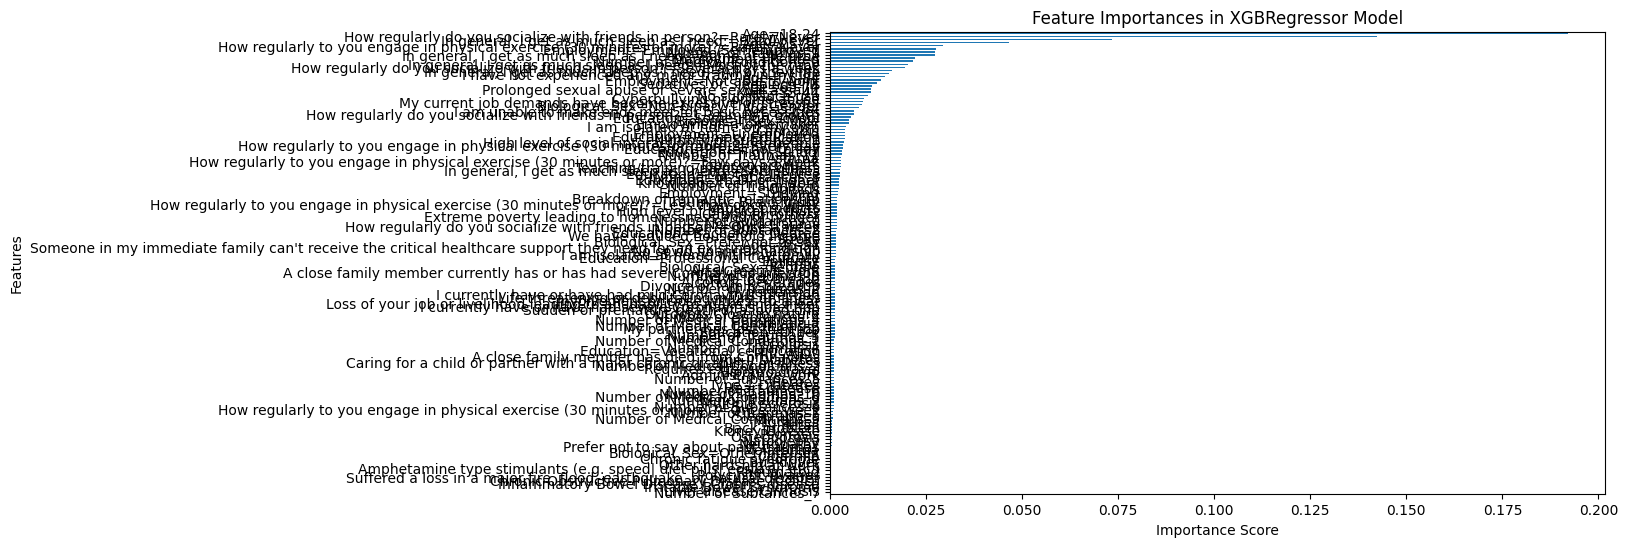

In [164]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'dataR' and a target column 'TargetColumnName'
X = dataR.drop('Overall MHQ', axis=1)
y = dataR['Overall MHQ']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit the XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a pandas series for easy plotting
importances = pd.Series(feature_importances, index=X.columns)

# Plotting
importances.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importances in XGBRegressor Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


In [167]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from tabulate import tabulate

# Assuming you have a DataFrame 'dataR' and a target column 'TargetColumnName'
X = dataR.drop('Overall MHQ', axis=1)
y = dataR['Overall MHQ']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit the XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for the feature importances
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Print the sorted importances in a tabular format
print(tabulate(importances_df, headers='keys', tablefmt='pretty', showindex=False))


+------------------------------------------------------------------------------------------------------------------+------------------------+
|                                                     Feature                                                      |       Importance       |
+------------------------------------------------------------------------------------------------------------------+------------------------+
|                                                    Age=18-24                                                     |  0.19203628599643707   |
|                       How regularly do you socialize with friends in person?=Rarely/Never                        |  0.14233317971229553   |
|                              In general, I get as much sleep as I need:=Hardly ever                              |  0.07331547141075134   |
|                                                    Age=25-34                                                     |   0.0465790256857872   |
|     

In [168]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tabulate import tabulate

# Assuming you have a DataFrame 'dataR' and a target column 'TargetColumnName'
X = dataR.drop('Overall MHQ', axis=1)
y = dataR['Overall MHQ']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit the RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for the feature importances
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Print the sorted importances in a tabular format
print(tabulate(importances_df, headers='keys', tablefmt='pretty', showindex=False))


+------------------------------------------------------------------------------------------------------------------+------------------------+
|                                                     Feature                                                      |       Importance       |
+------------------------------------------------------------------------------------------------------------------+------------------------+
|                                                    Age=18-24                                                     |  0.12164658121836823   |
|                       How regularly do you socialize with friends in person?=Rarely/Never                        |  0.08941023358318345   |
|                              In general, I get as much sleep as I need:=Hardly ever                              |  0.04744494509713065   |
|                                                    Age=25-34                                                     |  0.03784233484906561   |
|     

# Run for multiple categories


In [29]:

categorical_feature_list = ['Language', 'Age', 'Biological_Sex', 'Region']
for catf in categorical_feature_list:
    dataL[catf] = data[catf]

categorical_feature = 'Age'
# Drop all columns from dataL except the one specified in categorical_feature
for feature in categorical_feature_list:
    if feature != categorical_feature:
        dataL.drop(feature, axis=1, inplace=True)


dataL.columns.tolist()


['Age=18-24',
 'Age=25-34',
 'Age=35-44',
 'Age=45-54',
 'Age=55-64',
 'Age=65-74',
 'Age=75-84',
 "Education=Bachelor's Degree",
 'Education=High School',
 "Education=Master's Degree",
 'Education=Other',
 'Education=Ph.D. or higher',
 'Education=Prefer not to say',
 'Education=Primary Education',
 'Education=Professional Certificate',
 'Education=Some High School',
 'Education=Vocational certification',
 'Employment=Employed /Self employed',
 'Employment=Homemaker',
 'Employment=Not able to work',
 'Employment=Retired',
 'Employment=Studying',
 'Employment=Unemployed',
 'In general, I get as much sleep as I need:=All of the time',
 'In general, I get as much sleep as I need:=Hardly ever',
 'In general, I get as much sleep as I need:=Most of the time',
 'In general, I get as much sleep as I need:=Some of the time',
 'In general, I get as much sleep as I need:=Sometimes',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Every day',
 'How regularly to you engage 

# XGBOOST


In [30]:
def run_model_for_each_category(data, categorical_feature, target_col, xgb_params, test_size, random_state):
    category_results = {}

    # Get unique values in the categorical feature
    unique_categories = data[categorical_feature].unique()

    for category in unique_categories:
        # Segmenting the data
        category_data = data[data[categorical_feature] == category]

        # Drop the categorical feature column from this segment
        category_data = category_data.drop(columns=[categorical_feature])

        # Ensure the segment is not empty
        if not category_data.empty:
            # Run the XGBoost model for this segment
            performance_metrics, feature_importances = run_xgboost2(
                category_data, target_col, xgb_params, test_size, random_state)

            # Store the results in the dictionary
            category_results[category] = {
                'performance_metrics': performance_metrics,
                'feature_importances': feature_importances
            }
    
    return category_results

# Define your XGBoost parameters
xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1
}
# Choose the categorical feature for segmentation
#categorical_feature = 'Language'  # Replace with your chosen feature

# Running the model for each category in the chosen feature
results = run_model_for_each_category(dataL, categorical_feature, 'MHQ Sign', xgb_params, test_size=0.3, random_state=42)




In [21]:
from tabulate import tabulate

# Assuming 'results' is a dictionary containing the results for each category
# and each entry in 'results' is another dictionary with 'performance_metrics' as a key
# Here's how you could use 'tabulate' to print a table for 'performance_metrics'

# First, create a list of dictionaries for easier conversion to DataFrame
metrics_list = []
for category, result in results.items():
    metrics = result['performance_metrics']
    metrics['Category'] = category
    metrics_list.append(metrics)

# Now convert this list of dictionaries to a DataFrame
performance_metrics_df = pd.DataFrame(metrics_list)

# Set the category as the index
performance_metrics_df.set_index('Category', inplace=True)

# Use tabulate to print the table
print(tabulate(performance_metrics_df, headers='keys', tablefmt='presto'))


 Category   |   accuracy |   precision |   recall |       f1 |   roc_auc
------------+------------+-------------+----------+----------+-----------
 Age=45-54  |   0.818829 |    0.796005 | 0.818829 | 0.796098 |  0.78074
 Age=18-24  |   0.673135 |    0.673295 | 0.673135 | 0.673134 |  0.739455
 Age=55-64  |   0.856933 |    0.829953 | 0.856933 | 0.831339 |  0.775852
 Age=35-44  |   0.769128 |    0.745424 | 0.769128 | 0.747808 |  0.745433
 Age=65-74  |   0.91195  |    0.880766 | 0.91195  | 0.886387 |  0.746303
 Age=75-84  |   0.941305 |    0.916763 | 0.941305 | 0.921696 |  0.700435
 Age=25-34  |   0.697709 |    0.68915  | 0.697709 | 0.688826 |  0.738028
 Unknown    |   0.955947 |    0.947297 | 0.955947 | 0.944601 |  0.718047


# Feature Importance


In [31]:
def compare_feature_importance_rankings_with_average(results):
    """
    Compare the rankings of feature importances across different categories and calculate average rank.

    Parameters:
    results (dict): The output from run_model_for_each_category containing 
                    'performance_metrics' and 'feature_importances' for each category.

    Returns:
    DataFrame: A DataFrame showing the ranking of each feature within each category and their average rank.
    """
    feature_rankings = {}

    for category, data in results.items():
        # Sort features by their importance in descending order
        sorted_features = data['feature_importances'].sort_values(by='Importance', ascending=False)
        #print(sorted_features)
        # Assign ranks to the features
        sorted_features['Rank'] = range(1, len(sorted_features) + 1)
        # Store the rankings for this category, with feature names as index
        feature_rankings[category] = sorted_features.set_index('Feature')['Rank']

    # Convert the dictionary to a DataFrame for easier analysis
    feature_rankings_df = pd.DataFrame(feature_rankings)
    
    # Calculate the average rank for each feature
    feature_rankings_df['Average Rank'] = feature_rankings_df.mean(axis=1)
    
    # Sort the DataFrame based on the average rank
    feature_rankings_df = feature_rankings_df.sort_values(by='Average Rank')

    return feature_rankings_df

# Assuming `results` is your dictionary containing the feature importances from each category
feature_importance_ranks = compare_feature_importance_rankings_with_average(results)
# print(feature_rankings_df)

print(tabulate(feature_importance_ranks, headers='keys', tablefmt='presto'), "\n")

 Feature                                                                                                          |   Age=45-54 |   Age=18-24 |   Age=55-64 |   Age=35-44 |   Age=65-74 |   Age=75-84 |   Age=25-34 |   Unknown |   Average Rank
------------------------------------------------------------------------------------------------------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-----------+----------------
 How regularly do you socialize with friends in person?=Rarely/Never                                              |           2 |           2 |           1 |           2 |           2 |           1 |           2 |         5 |          2.125
 In general, I get as much sleep as I need:=Hardly ever                                                           |           3 |           1 |           2 |           1 |           1 |           2 |           1 |         9 |          2.5
 Employment=Not able to work         

Performance Metrics:
{'accuracy': 0.7982877427437879, 'precision': 0.7860159358559414, 'recall': 0.7982877427437879, 'f1': 0.7863844252581936, 'roc_auc': 0.829236442180266}


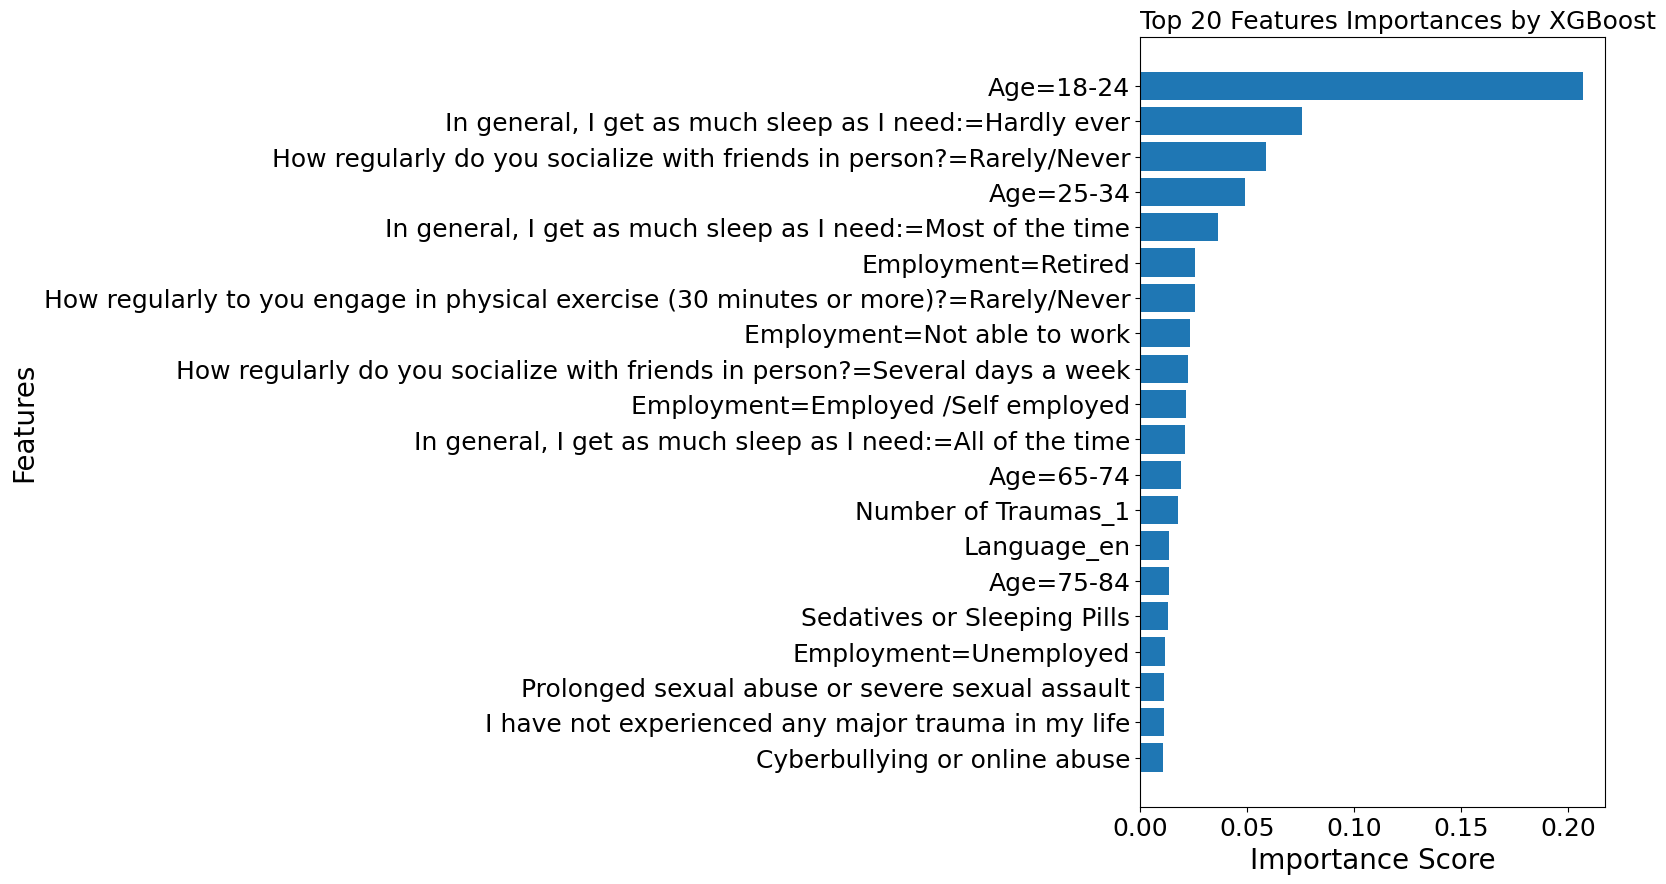

In [86]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'dataL' is your DataFrame and 'run_xgboost2' is defined as per your previous message
data_copy = dataL.copy()  # Create a copy of the data

# Specify XGBoost parameters (modify as needed)
xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1
}

# Run the function
performance_metrics, feature_importances_df = run_xgboost2(data_copy, 'MHQ Sign', xgb_params)

# Display performance metrics
print("Performance Metrics:")
print(performance_metrics)

# Plotting top feature importances
top_features = feature_importances_df.head(20)  # Selecting top 20 features

plt.figure(figsize=(6, 10))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance Score', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('Top 20 Features Importances by XGBoost', fontsize=18, loc='left')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


In [13]:
dataL=dataL.drop(columns='Age')

In [16]:
#dataL.columns.tolist()

In [ ]:
dataL_18_24 = dataL[dataL['Age=18-24'] == 1]
dataL_45_54 = dataL[dataL['Age=45-54'] == 1]

dataR_18_24 = dataR[dataR['Age=18-24'] == 1]
dataR_45_54 = dataR[dataR['Age=45-54'] == 1]

In [18]:
dataL = dataL[dataL['Age=18-24'] == 1]
dataL.shape


(59951, 154)

In [85]:
dataL.shape

(271374, 154)

In [34]:
def compare_feature_importance_rankings_with_values(results):
    """
    Compare the rankings of feature importances across different categories and calculate average rank, and return sorted feature importances.

    Parameters:
    results (dict): The output from run_model_for_each_category containing 
                    'performance_metrics' and 'feature_importances' for each category.

    Returns:
    Tuple: (DataFrame showing average rank, Dictionary of DataFrames showing sorted feature importances for each category)
    """
    feature_rankings = {}
    sorted_feature_importances = {}

    for category, data in results.items():
        # Sort features by their importance in descending order
        sorted_features = data['feature_importances'].sort_values(by='Importance', ascending=False)
        #print(sorted_features)
        # Assign ranks to the features
        sorted_features['Rank'] = range(1, len(sorted_features) + 1)
        # Store the rankings for this category, with feature names as index
        feature_rankings[category] = sorted_features['Rank']
        # Store the sorted feature importances for this category
        sorted_feature_importances[category] = sorted_features

    # Convert the rankings dictionary to a DataFrame for easier analysis
    feature_rankings_df = pd.DataFrame(feature_rankings)
    # Calculate the average rank for each feature
    feature_rankings_df['Average Rank'] = feature_rankings_df.mean(axis=1)
    # Sort the DataFrame based on the average rank
    feature_rankings_df = feature_rankings_df.sort_values(by='Average Rank')

    return feature_rankings_df, sorted_feature_importances

# Example usage:
# Assuming `results` is your dictionary containing the feature importances from each category
feature_rankings_df, sorted_importances = compare_feature_importance_rankings_with_values(results)


In [75]:
# Define feature_map using original and shortened names
feature_map = {
    'Age=18-24': "Age=18-24",
    'How regularly do you socialize with friends in person?=Rarely/Never': "Socialize Rarely/Never",
    'In general, I get as much sleep as I need:=Hardly ever': "Sleep Hardly Ever",
    'Age=25-34': "Age=25-34",
    'Employment=Retired': "Retired",
    'Employment=Employed /Self employed': "Employed/Self-employed",
    'In general, I get as much sleep as I need:=Most of the time': "Sleep Mostly",
    'How regularly to you engage in physical exercise (30 minutes or more)?=Rarely/Never': "Exercise Rarely/Never",
    'Employment=Not able to work': "Not able to work",
    'Number of Traumas_1': "Traumas 1",
    'In general, I get as much sleep as I need:=All of the time': "Sleep Always",
    'Age=65-74': "Age=65-74",
    'Age=75-84': "Age=75-84",
    'Number of Medical Conditions_0': "Medical Conditions = 0",
    'Age=35-44': "Age=35-44",
    'Biological_Sex=Non-binary/Third Gender': "Non-binary/Third Gender",
    'I have not experienced any major trauma in my life': "No major trauma",
    'How regularly do you socialize with friends in person?=Several days a week': "Socialize Often",
    'Sedatives or Sleeping Pills': "Sedatives/Sleep Pills",
    'Prolonged sexual abuse or severe sexual assault': "Sexual abuse/assault",
    # Additional mappings for new features
    'In general, I get as much sleep as I need:=Some of the time': "Sleep Some time",
    'My current job demands have become excessive or stressful': "Excessive Job Stress",
    'Cyberbullying or online abuse': "Cyberbullying/Online Abuse",
     'Education=Primary Education': "Primary Education",                                                                       
     "Education=Bachelor's Degree": "Bachelor's Degree",  
    
     "Employment=Employed /Self employed":  "Employed",                                                                              
                                                                                                                            
                                                                                              
     "Employment=Unemployed":   "Unemployed",                                                                                         
     "Language_es":    "Spanish Lang.",  
    "Language_en":    "English Lang.",  
     "Education=Master's Degree":       "Master's Degree",                                                                                  
     "I am isolated at home on my own":   "Isolated at home",                                                                       
                                                                                                   
     "I am unable to make ends meet for basic necessities":   "Struggling financially",                                                            
     "Education=Some High School":       "Some High School"                                                                                
    
    
    # Add any other new feature mappings that are required for your dataset here
}


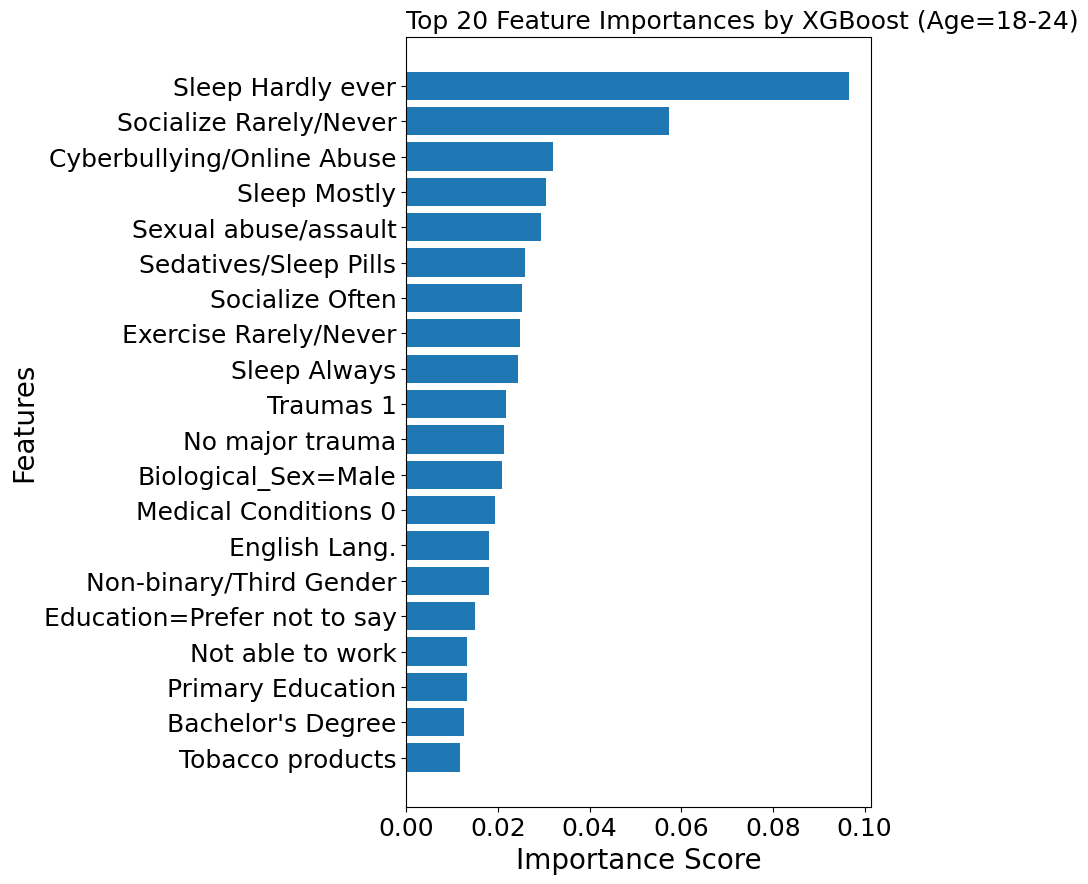

In [76]:
import matplotlib.pyplot as plt

# Assuming sorted_importances is your dictionary
age_group = 'Age=18-24'

# Extracting the DataFrame for the specified age group
age_group_df = sorted_importances[age_group]

# Selecting the top 20 features based on their importance
top_features = age_group_df.nlargest(20, 'Importance')

# Plotting the horizontal bar chart
plt.figure(figsize=(6, 10))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance Score', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title(f'Top 20 Feature Importances by XGBoost ({age_group})', fontsize=18, loc='left')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


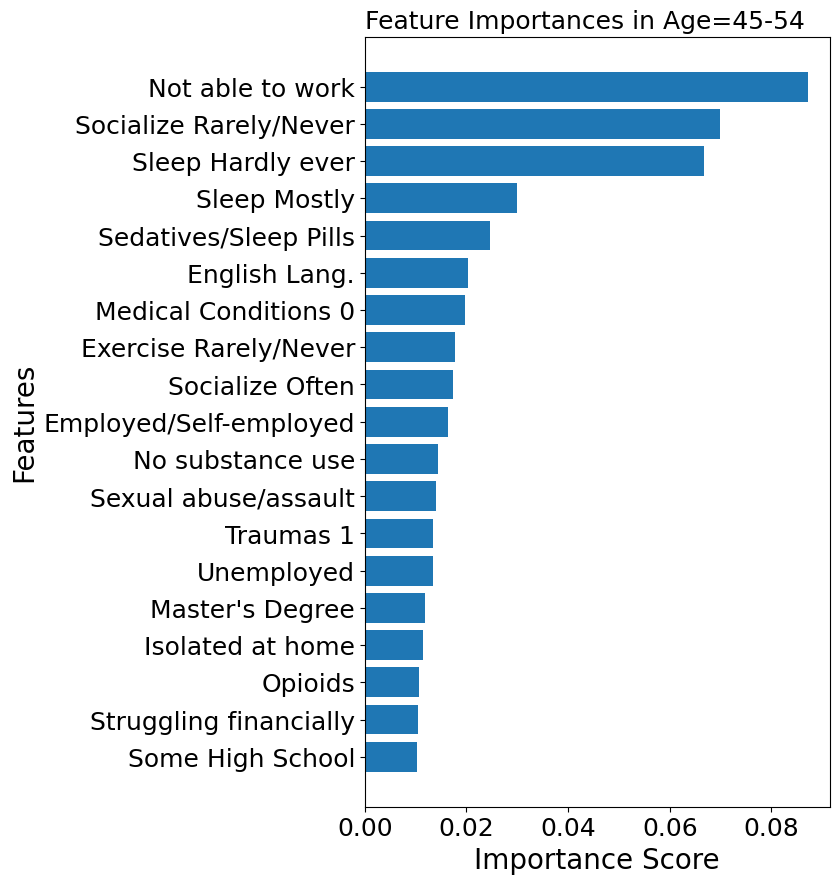

In [77]:
import matplotlib.pyplot as plt


plt.rcParams.update({'font.size': 18})  # You can change '18' to your desired size


# Assuming sorted_importances is your dictionary and feature_map is your mapping dictionary
age_group = 'Age=45-54'

# Extracting the DataFrame for the specified age group
age_group_df = sorted_importances[age_group]

# Renaming the features based on the feature_map
age_group_df['Feature'] = age_group_df['Feature'].map(feature_map).fillna(age_group_df['Feature'])

# Selecting the top 20 features based on their importance
top_features = age_group_df.nlargest(20, 'Importance')

# Plotting the horizontal bar chart
plt.figure(figsize=(6, 10))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance Score', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title(f'Feature Importances in {age_group}', fontsize=18, loc='left')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


In [35]:
sorted_importances

{'Age=45-54':                                                Feature  Importance  Rank
 19                         Employment=Not able to work    0.087125     1
 35   How regularly do you socialize with friends in...    0.069825     2
 24   In general, I get as much sleep as I need:=Har...    0.066763     3
 25   In general, I get as much sleep as I need:=Mos...    0.029993     4
 90                         Sedatives or Sleeping Pills    0.024586     5
 ..                                                 ...         ...   ...
 6                                            Age=75-84    0.000000   149
 40                       Biological_Sex=Other/Intersex    0.000000   150
 52   Suffered a loss in a major fire, flood, earthq...    0.000000   151
 54                Prefer not to say about past traumas    0.000000   152
 152                              Number of Subtances_7    0.000000   153
 
 [153 rows x 3 columns],
 'Age=18-24':                                                Feature  Im

In [32]:
import pandas as pd
from tabulate import tabulate

def print_combined_feature_importances(sorted_importances):
    # Extract and combine feature names and importances from each category
    combined_importances_df = pd.DataFrame()
    
    for category, df in sorted_importances.items():
        # Create a DataFrame with both 'Feature' and 'Importance' columns
        importance_df = df[['Feature', 'Importance']].rename(columns={'Importance': f'{category} Importance'})
        
        # If it's the first category, initialize the combined DataFrame
        if combined_importances_df.empty:
            combined_importances_df = importance_df
        else:
            # Combine the DataFrames
            combined_importances_df = combined_importances_df.merge(importance_df, on='Feature', how='outer')

    # Display using tabulate
    print(tabulate(combined_importances_df, headers='keys', tablefmt='presto'), "\n")

# Example usage
# Assuming 'sorted_importances' is your dictionary with sorted importances for each category
print_combined_feature_importances(sorted_importances)


     | Feature                                                                                                          |   Age=45-54 Importance |   Age=18-24 Importance |   Age=55-64 Importance |   Age=35-44 Importance |   Age=65-74 Importance |   Age=75-84 Importance |   Age=25-34 Importance |   Unknown Importance
-----+------------------------------------------------------------------------------------------------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+----------------------
   0 | Employment=Not able to work                                                                                      |            0.0871245   |            0.0133568   |            0.0568259   |             0.0357692  |             0.0155857  |            0.0142726   |            0.0230066   |           0.0395125
   1 | How regularly do you socialize with fri

In [10]:
dataL.columns.tolist()


['Age=18-24',
 'Age=25-34',
 'Age=35-44',
 'Age=45-54',
 'Age=55-64',
 'Age=65-74',
 'Age=75-84',
 "Education=Bachelor's Degree",
 'Education=High School',
 "Education=Master's Degree",
 'Education=Other',
 'Education=Ph.D. or higher',
 'Education=Prefer not to say',
 'Education=Primary Education',
 'Education=Professional Certificate',
 'Education=Some High School',
 'Education=Vocational certification',
 'Employment=Employed /Self employed',
 'Employment=Homemaker',
 'Employment=Not able to work',
 'Employment=Retired',
 'Employment=Studying',
 'Employment=Unemployed',
 'In general, I get as much sleep as I need:=All of the time',
 'In general, I get as much sleep as I need:=Hardly ever',
 'In general, I get as much sleep as I need:=Most of the time',
 'In general, I get as much sleep as I need:=Some of the time',
 'In general, I get as much sleep as I need:=Sometimes',
 'How regularly to you engage in physical exercise (30 minutes or more)?=Every day',
 'How regularly to you engage 

In [198]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

def calculate_information_gain_for_segments(data, categorical_feature, target_feature):
    """
    Calculate the information gain for all features within each data segment 
    defined by the categorical feature.

    Parameters:
    data (DataFrame): The input data.
    categorical_feature (str): The name of the categorical feature to segment the data.
    target_feature (str): The name of the target feature for information gain calculation.

    Returns:
    info_gain_df (DataFrame): A DataFrame with information gain values for all features within each segment.
    """
    # Unique categories in the categorical feature
    categories = data[categorical_feature].unique()
    
    # Initialize a DataFrame to hold the information gain for each feature per segment
    info_gain_df = pd.DataFrame(index=data.drop(columns=[categorical_feature, target_feature]).columns)

    # Calculate information gain for each feature within each segment
    for category in categories:
        print(f"processing category {category}")
        # Segment the data
        segment = data[data[categorical_feature] == category]
        if segment.empty:
            # If the segment is empty, continue to the next category
            continue
        X = segment.drop(columns=[categorical_feature, target_feature])
        y = segment[target_feature]

        # Compute information gain for each feature in the segment
        info_gain = mutual_info_classif(X, y, discrete_features='auto')

        # Add the information gain values to the DataFrame
        info_gain_df[category] = info_gain

    return info_gain_df




In [199]:
# Example usage:
# Assuming 'data' is your DataFrame, 'Region' is the categorical feature, and 'MHQ Sign' is the target feature
info_gain_df = calculate_information_gain_for_segments(dataL, categorical_feature, 'MHQ Sign')

print(tabulate(info_gain_df, headers='keys', tablefmt='presto'))

processing category Age=45-54
processing category Age=18-24
processing category Age=55-64
processing category Age=35-44
processing category Age=65-74
processing category Age=75-84
processing category Age=25-34
processing category Unknown
                                                                                                                  |   Age=45-54 |   Age=18-24 |   Age=55-64 |   Age=35-44 |   Age=65-74 |   Age=75-84 |   Age=25-34 |     Unknown
------------------------------------------------------------------------------------------------------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------
 Age=18-24                                                                                                        | 0.00292144  | 0.00332094  | 0.000294117 | 0.00202725  | 0.000122497 | 0.00207542  | 0.00211723  | 0.00491088
 Age=25-34                                                                          

In [200]:
save_results_to_excel('Language', '/Users/jerzybala/Desktop', results, feature_importance_ranks, info_gain_df)

NameError: name 'save_results_to_excel' is not defined

# Print Results in Tabular Form

In [ ]:


def combine_performance_metrics(category_results, category_name):
    # Combining performance metrics into a single DataFrame
    metrics_df = pd.DataFrame()
    for category, result in category_results.items():
        temp_df = pd.DataFrame([result['performance_metrics']])
        temp_df[category_name] = category
        metrics_df = pd.concat([metrics_df, temp_df], ignore_index=True)

    # Displaying the combined metrics
    metrics_df.set_index(category_name, inplace=True)
    return metrics_df

# Example usage:
# Assuming 'results' is the output from run_model_for_each_category
category_name = 'Age'  # Replace with the name of your categorical feature
combined_metrics = combine_performance_metrics(results, category_name)
print(combined_metrics)


# Visualize Performance Metrics

In [ ]:
def plot_performance_metrics(metrics_df, category_name):
    # Determine which columns to plot
    if category_name in metrics_df.columns:
        metrics_to_plot = metrics_df.columns.drop(category_name)
    else:
        metrics_to_plot = metrics_df.columns

    # Plotting the performance metrics for each category
    for metric in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=metrics_df.index, y=metrics_df[metric])
        plt.title(f'{metric.capitalize()} per {category_name}')
        plt.xticks(rotation=45)
        plt.show()

# Example usage:
category_name = 'Age'  # Replace with the actual name of your categorical feature
plot_performance_metrics(combined_metrics, category_name)


# Visualize Feature Importances

In [ ]:
plot_performance_metrics(combined_metrics, 'Age')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importances_for_categories(results, feature_name, top_n=10):
    """
    Plot feature importances for each category in a specified feature.

    Parameters:
    results (dict): Dictionary containing feature importances for each category.
    feature_name (str): Name of the categorical feature.
    top_n (int): Number of top features to display in the plot.
    """
    for category, result in results.items():
        top_features = result['feature_importances'].head(top_n)
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Top {top_n} Feature Importances for {feature_name}: {category}')
        plt.ylabel('Feature Importance')
        plt.xlabel('Features')
        plt.show()

# Example usage
plot_feature_importances_for_categories(results, "Region", top_n=20)


In [ ]:
top_n = 20  # Number of top features to display

for category, result in results.items():
    print(category)
    top_features = result['feature_importances'].nlargest(top_n, 'Importance')
    print(top_features.to_string(index=False))  # Displaying without the DataFrame index
    print("_____________________\n")


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

def calculate_and_visualize_kl_divergence(data, cat_var1, cat_var2):
    """
    Calculate the KL divergence between two categorical columns in a DataFrame
    and visualize it using a heatmap.

    :param data: Pandas DataFrame containing the data.
    :param cat_var1: Name of the first categorical column.
    :param cat_var2: Name of the second categorical column.
    """
    # Calculate the KL divergence
    prob_dist1 = data[cat_var1].value_counts(normalize=True)
    prob_dist2 = data[cat_var2].value_counts(normalize=True)

    # Align the distributions
    all_categories = prob_dist1.index.union(prob_dist2.index)
    aligned_dist1 = prob_dist1.reindex(all_categories, fill_value=0)
    aligned_dist2 = prob_dist2.reindex(all_categories, fill_value=0)

    kl_divergence = entropy(aligned_dist1, aligned_dist2)

    # Create a heatmap for visualization
    kl_matrix = pd.DataFrame([[kl_divergence]], index=[cat_var1], columns=[cat_var2])
    
    plt.figure(figsize=(7, 6))
    sns.heatmap(kl_matrix, annot=True, cmap="coolwarm", cbar_kws={'label': 'KL Divergence'})
    plt.title(f"KL Divergence: {cat_var1} vs. {cat_var2}")
    plt.show()

    return kl_matrix

kl_div_matrix = calculate_and_visualize_kl_divergence(data, 'Region', 'Age')


# THE VERY END 